In [1]:
import pandas as pd
from helpers import get_data_path, create_data_out_path, split_dataframe
import os
import re
from difflib import get_close_matches
import spotipy
from spotipy.oauth2 import SpotifyOAuth

scraped_data_folder_path = get_data_path("scraped_chart_data")
scraped_files = os.listdir(scraped_data_folder_path)
len(scraped_files)


1750

## Mapping region codes to region names from existing dataset


In [2]:
country_iso_codes = pd.read_csv(
    get_data_path(
        "iso_codes.csv",
        download_url="https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv",
    ),
)[["name", "alpha-2"]]
country_iso_codes["alpha-2"] = country_iso_codes["alpha-2"].str.lower()
country_iso_codes


,name,alpha-2
0,Afghanistan,af
1,Åland Islands,ax
2,Albania,al
3,Algeria,dz
4,American Samoa,as
...,...,...
244,Wallis and Futuna,wf
245,Western Sahara,eh
246,Yemen,ye
247,Zambia,zm


In [3]:
def extract_region_code(file_name: str):
    return re.search(r"\-([a-z]*)\-", file_name).groups()[0]


region_codes_in_data = pd.Series(
    list(set([extract_region_code(fname) for fname in scraped_files])), name="alpha-2"
)
region_codes_in_data


0         sv
1         no
2         de
3         hn
4         gb
5         us
6         ie
7         co
8         pt
9         ph
10        ch
11        hk
12        tw
13        au
14        mx
15        cr
16        nz
17        my
18        ec
19        cl
20        ar
21        es
22        pa
23        hu
24        jp
25        sk
26        is
27        pe
28        cz
29        br
30        se
31        nl
32        dk
33        pl
34        gr
35        gt
36        it
37        tr
38        id
39    global
40        py
41        sg
42        uy
43        at
44        ca
45        do
46        fr
47        bo
48        be
49        fi
Name: alpha-2, dtype: object

In [4]:
codes_and_names = pd.merge(region_codes_in_data, country_iso_codes, how="left").rename(
    columns={"alpha-2": "code", "name": "country_name"}
)
codes_and_names.loc[codes_and_names.code == "global", "country_name"] = "Global"
codes_and_names


,code,country_name
0,sv,El Salvador
1,no,Norway
2,de,Germany
3,hn,Honduras
4,gb,United Kingdom of Great Britain and Northern I...
5,us,United States of America
6,ie,Ireland
7,co,Colombia
8,pt,Portugal
9,ph,Philippines


In [5]:
existing_data = pd.read_csv(
    get_data_path(
        "top50_almost_complete.csv",
    ),
)


In [6]:
all_region_names = list(existing_data.region.drop_duplicates())
all_region_names


['Argentina',
 'Australia',
 'Austria',
 'Belgium',
 'Colombia',
 'Bolivia',
 'Brazil',
 'Canada',
 'Denmark',
 'Chile',
 'Costa Rica',
 'Czech Republic',
 'Dominican Republic',
 'Ecuador',
 'El Salvador',
 'Finland',
 'France',
 'Germany',
 'Global',
 'Greece',
 'Guatemala',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'Indonesia',
 'Ireland',
 'Italy',
 'Japan',
 'Malaysia',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Panama',
 'Paraguay',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Singapore',
 'Slovakia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Turkey',
 'United Kingdom',
 'United States',
 'Uruguay']

In [7]:
# join using fuzzy matching
def get_close_match_if_exists(country_name):
    matches = get_close_matches(country_name, all_region_names)
    if len(matches) > 0:
        return matches[0]
    else:
        return None


codes_and_names["region_name"] = codes_and_names["country_name"].apply(
    get_close_match_if_exists
)
codes_and_names


,code,country_name,region_name
0,sv,El Salvador,El Salvador
1,no,Norway,Norway
2,de,Germany,Germany
3,hn,Honduras,Honduras
4,gb,United Kingdom of Great Britain and Northern I...,None
5,us,United States of America,United States
6,ie,Ireland,Ireland
7,co,Colombia,Colombia
8,pt,Portugal,Portugal
9,ph,Philippines,Philippines


In [8]:
codes_and_names.loc[codes_and_names.region_name.isna()]


,code,country_name,region_name
4,gb,United Kingdom of Great Britain and Northern I...,None
12,tw,"Taiwan, Province of China",None
28,cz,Czechia,None
47,bo,Bolivia (Plurinational State of),None


In [9]:
missing_mappings = [
    ("tw", "Taiwan"),
    ("cz", "Czech Republic"),
    ("bo", "Bolivia"),
    ("gb", "United Kingdom"),
]
for (code, region_name) in missing_mappings:
    codes_and_names.loc[codes_and_names.code == code, "region_name"] = region_name

region_code_to_name = (
    codes_and_names.merge(
        pd.Series(all_region_names, name="region_name"), on="region_name"
    )[["code", "region_name"]]
    .rename(columns={"region_name": "name"})
    .set_index("code")
)
len(region_code_to_name) == len(all_region_names)


True

In [10]:
region_code_to_name = region_code_to_name["name"]
region_code_to_name


code
sv               El Salvador
no                    Norway
de                   Germany
hn                  Honduras
gb            United Kingdom
us             United States
ie                   Ireland
co                  Colombia
pt                  Portugal
ph               Philippines
ch               Switzerland
hk                 Hong Kong
tw                    Taiwan
au                 Australia
mx                    Mexico
cr                Costa Rica
nz               New Zealand
my                  Malaysia
ec                   Ecuador
cl                     Chile
ar                 Argentina
es                     Spain
pa                    Panama
hu                   Hungary
jp                     Japan
sk                  Slovakia
is                   Iceland
pe                      Peru
cz            Czech Republic
br                    Brazil
se                    Sweden
nl               Netherlands
dk                   Denmark
pl                    Poland
gr       

## Create final cleaned dataset


Let's look at our existing data first:


In [11]:
existing_data


,title,rank,date,artist,url,region,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,MOVE_UP,153956.0
...,...,...,...,...,...,...,...,...
4477827,Explícale (feat. Bad Bunny),46,2018-01-31,Yandel,https://open.spotify.com/track/1LszjjoVwDDZcWU...,Uruguay,MOVE_DOWN,4560.0
4477828,Nena Maldicion (feat. Lenny Tavarez),47,2018-01-31,"Paulo Londra, Lenny Tavárez",https://open.spotify.com/track/3TnhQSRwT3AVMdX...,Uruguay,MOVE_UP,4406.0
4477829,Ahora Dice,48,2018-01-31,"Chris Jedi, J Balvin, Ozuna, Arcangel",https://open.spotify.com/track/22eADXu8DfOAUED...,Uruguay,SAME_POSITION,4316.0
4477830,La fórmula (feat. Chris Jedi),49,2018-01-31,"De La Ghetto, Daddy Yankee, Ozuna",https://open.spotify.com/track/4XCQtUoRSh22Ep1...,Uruguay,SAME_POSITION,4272.0


Let's drop the trend column. It's computable from the data anyway!


In [12]:
existing_data.drop(columns="trend", inplace=True)


In [13]:
existing_data.artist


0                                        Shakira
1                                   Ricky Martin
2                                           CNCO
3          J Balvin, Pharrell Williams, BIA, Sky
4                                   Daddy Yankee
                           ...                  
4477827                                   Yandel
4477828              Paulo Londra, Lenny Tavárez
4477829    Chris Jedi, J Balvin, Ozuna, Arcangel
4477830        De La Ghetto, Daddy Yankee, Ozuna
4477831                  J Balvin, Willy William
Name: artist, Length: 4477832, dtype: object

The scraped data contains only track URIs.
For example: `spotify:track:2rb5MvYT7ZIxbKW5hfcHx8`

It would be convenient if the existing data also just used them instead of full Spotify song links.


What's the format of the URLs in the existing data?


In [14]:
existing_data.url[0]


'https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg'

In [15]:
def convert_to_uri(track_url: str):
    return track_url.replace("https://open.spotify.com/track/", "spotify:track:")


convert_to_uri(existing_data.url[0])


'spotify:track:6mICuAdrwEjh6Y6lroV2Kg'

Just make sure the URIs have equal length:


In [16]:
len(convert_to_uri(existing_data.url[0])) == len("spotify:track:2rb5MvYT7ZIxbKW5hfcHx8")


True

In [17]:
existing_data["uri"] = existing_data.url.apply(convert_to_uri)
existing_data.drop(columns="url", inplace=True)


In [18]:
existing_data


,title,rank,date,artist,region,streams,uri
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,253019.0,spotify:track:6mICuAdrwEjh6Y6lroV2Kg
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,Argentina,223988.0,spotify:track:7DM4BPaS7uofFul3ywMe46
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,Argentina,210943.0,spotify:track:3AEZUABDXNtecAOSC1qTfo
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",Argentina,173865.0,spotify:track:6rQSrBHf7HlZjtcMZ4S4bO
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,Argentina,153956.0,spotify:track:58IL315gMSTD37DOZPJ2hf
...,...,...,...,...,...,...,...
4477827,Explícale (feat. Bad Bunny),46,2018-01-31,Yandel,Uruguay,4560.0,spotify:track:1LszjjoVwDDZcWUQbzeDLG
4477828,Nena Maldicion (feat. Lenny Tavarez),47,2018-01-31,"Paulo Londra, Lenny Tavárez",Uruguay,4406.0,spotify:track:3TnhQSRwT3AVMdXw5JPq0x
4477829,Ahora Dice,48,2018-01-31,"Chris Jedi, J Balvin, Ozuna, Arcangel",Uruguay,4316.0,spotify:track:22eADXu8DfOAUEDw4vU8qy
4477830,La fórmula (feat. Chris Jedi),49,2018-01-31,"De La Ghetto, Daddy Yankee, Ozuna",Uruguay,4272.0,spotify:track:4XCQtUoRSh22Ep18ULmDnT


### process new scraped files


In [19]:
dfs = []


In [20]:
def extract_date(file_name: str):
    date = re.search(r"[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]", file_name).group()
    return date


# example
extract_date(scraped_files[0])


'2021-12-13'

In [21]:
incomplete_data = []


def create_df_in_format_of_existing_data(file_name):
    data = pd.read_csv(
        get_data_path(os.path.join(scraped_data_folder_path, file_name))
    ).rename(columns={"track_name": "title", "artist_names": "artist"})
    r_code = extract_region_code(file_name)
    r_name = region_code_to_name[r_code]
    data["region"] = r_name
    date = extract_date(file_name)
    data["date"] = date
    data = data[existing_data.columns]

    # keep only top 50
    data = data.loc[data["rank"] <= 50]
    track_count = len(data)
    if track_count < 50:
        incomplete_data.append((r_name, date, file_name, track_count))
    return data


new_data = pd.concat(
    [create_df_in_format_of_existing_data(file_name) for file_name in scraped_files]
)
new_data


,title,rank,date,artist,region,streams,uri
0,ベテルギウス,1,2021-12-13,Yuuri,Japan,215005,spotify:track:2sf18cEv463VgqmdjDsFpw
1,ドライフラワー,2,2021-12-13,Yuuri,Japan,206931,spotify:track:7dH0dpi751EoguDDg3xx6J
2,残響散歌,3,2021-12-13,Aimer,Japan,206079,spotify:track:7v8wKvNQQIxkugCFFjrkaO
3,一途,4,2021-12-13,King Gnu,Japan,201641,spotify:track:7ncPjJBktLEOpstY5JOUMK
4,なんでもないよ、,5,2021-12-13,Macaroni Empitsu,Japan,187740,spotify:track:2PFzK3kMDDYKhGnugvNYf1
...,...,...,...,...,...,...,...
45,PORFA,46,2020-10-08,"Feid, Justin Quiles",Chile,73584,spotify:track:4TOmcZvw0gHa7GiXRbcYAW
46,Lean,47,2020-10-08,Mike Caride,Chile,73246,spotify:track:5DoLhdU27owX1NMrKLUbUl
47,La Difícil,48,2020-10-08,Bad Bunny,Chile,71215,spotify:track:6NfrH0ANGmgBXyxgV2PeXt
48,Yo Perreo Sola,49,2020-10-08,Bad Bunny,Chile,68428,spotify:track:0SqqAgdovOE24BzxIClpjw


In [22]:
incomplete_data = pd.DataFrame(
    incomplete_data, columns=["region", "date", "file_name", "track_count"]
).set_index(["region", "date"])
incomplete_data


,,file_name,track_count
region,date,,
Switzerland,2017-12-07,regional-ch-daily-2017-12-07.csv,46
Austria,2017-12-14,regional-at-daily-2017-12-14.csv,49
Slovakia,2017-01-04,regional-sk-daily-2017-01-04.csv,43
Panama,2021-08-13,regional-pa-daily-2021-08-13.csv,49
Bolivia,2017-11-11,regional-bo-daily-2017-11-11.csv,49
...,...,...,...
Austria,2017-12-08,regional-at-daily-2017-12-08.csv,47
Global,2017-11-12,regional-global-daily-2017-11-12.csv,49
Denmark,2017-07-21,regional-dk-daily-2017-07-21.csv,48


In [23]:
track_counts_new_data = incomplete_data.track_count


In [24]:
new_vs_existing = incomplete_data.join(
    track_counts_new_data, how="left", lsuffix="_new", rsuffix="_existing"
)
new_vs_existing


,,file_name,track_count_new,track_count_existing
region,date,,,
Switzerland,2017-12-07,regional-ch-daily-2017-12-07.csv,46,46
Austria,2017-12-14,regional-at-daily-2017-12-14.csv,49,49
Slovakia,2017-01-04,regional-sk-daily-2017-01-04.csv,43,43
Panama,2021-08-13,regional-pa-daily-2021-08-13.csv,49,49
Bolivia,2017-11-11,regional-bo-daily-2017-11-11.csv,49,49
...,...,...,...,...
Austria,2017-12-08,regional-at-daily-2017-12-08.csv,47,47
Global,2017-11-12,regional-global-daily-2017-11-12.csv,49,49
Denmark,2017-07-21,regional-dk-daily-2017-07-21.csv,48,48


In [25]:
new_vs_existing.loc[
    new_vs_existing.track_count_new > new_vs_existing.track_count_existing
]


,,file_name,track_count_new,track_count_existing
region,date,,,


That's sad! For 401 rows it looks like Spotify just doesn't provide better data than the data we already have.

I guess we'll have to live with that.


In [26]:
1 - len(incomplete_data) / len(new_data)


0.9953547639733565

Still, as we see above, we managed to get complete data for 99.5% of the other cases where we didn't have data before!


In [27]:
existing_data.date = pd.to_datetime(existing_data.date)
existing_data["source"] = "existing"
new_data.date = pd.to_datetime(new_data.date)
new_data["source"] = "new"


In [28]:
combined_data = pd.concat(
    [
        existing_data.set_index(["region", "date"]),
        new_data.set_index(["region", "date"]),
    ]
).sort_index()
combined_data


title  rank  \
region    date                                                    
Argentina 2017-01-01              Chantaje (feat. Maluma)     1   
          2017-01-01          Vente Pa' Ca (feat. Maluma)     2   
          2017-01-01           Reggaetón Lento (Bailemos)     3   
          2017-01-01                               Safari     4   
          2017-01-01                          Shaky Shaky     5   
...                                                   ...   ...   
Uruguay   2021-12-31                           Los Tragos    46   
          2021-12-31                                 Sabe    47   
          2021-12-31  Morad: Bzrp Music Sessions, Vol. 47    48   
          2021-12-31                           2:50 Remix    49   
          2021-12-31                               París    50   

                                                     artist   streams  \
region    date                                                          
Argentina 2017-01-01                                Shakira  253019.0   
          2017-01-01                           Ricky Martin  223988.0   
          2017-01-01                                   CNCO  210943.0   
          2017-01-01  J Balvin, Pharrell Williams, BIA, Sky  173865.0   
          2017-01-01                           Daddy Yankee  153956.0   
...                                                     ...       ...   
Uruguay   2021-12-31                    Reik, Maria Becerra   10707.0   
          2021-12-31           Nicki Nicole, Rauw Alejandro   10635.0   
          2021-12-31                        Bizarrap, Morad   10491.0   
          2021-12-31                        MYA, TINI, Duki   10388.0   
          2021-12-31                               Ingratax   10137.0   

                                                       uri    source  
region    date                                                        
Argentina 2017-01-01  spotify:track:6mICuAdrwEjh6Y6lroV2Kg  existing  
          2017-01-01  spotify:track:7DM4BPaS7uofFul3ywMe46  existing  
          2017-01-01  spotify:track:3AEZUABDXNtecAOSC1qTfo  existing  
          2017-01-01  spotify:track:6rQSrBHf7HlZjtcMZ4S4bO  existing  
          2017-01-01  spotify:track:58IL315gMSTD37DOZPJ2hf  existing  
...                                                    ...       ...  
Uruguay   2021-12-31  spotify:track:7iXJg4IUyrWont5YSQrbKP       new  
          2021-12-31  spotify:track:0XYZhJIcwKNjd0tjbSXwaQ       new  
          2021-12-31  spotify:track:39yyHtQ4tkjZzd8TfIBKQw       new  
          2021-12-31  spotify:track:5eyO0n1HiiSWdGaaSoK731       new  
          2021-12-31  spotify:track:4bF2y8rR7GUjrd5LNEvej3       new  

[4564157 rows x 6 columns]

In [29]:
len(combined_data)

4564157

In [30]:
combined_data_filtered = combined_data.reset_index()
combined_data_filtered = combined_data_filtered.drop_duplicates(
    subset=combined_data_filtered.columns.difference(["source"])
)
combined_data_filtered = combined_data_filtered.set_index(["region", "date", "rank"])
combined_data_filtered


title  \
region    date       rank                                        
Argentina 2017-01-01 1                 Chantaje (feat. Maluma)   
                     2             Vente Pa' Ca (feat. Maluma)   
                     3              Reggaetón Lento (Bailemos)   
                     4                                  Safari   
                     5                             Shaky Shaky   
...                                                        ...   
Uruguay   2021-12-31 46                             Los Tragos   
                     47                                   Sabe   
                     48    Morad: Bzrp Music Sessions, Vol. 47   
                     49                             2:50 Remix   
                     50                                 París   

                                                          artist   streams  \
region    date       rank                                                    
Argentina 2017-01-01 1                                   Shakira  253019.0   
                     2                              Ricky Martin  223988.0   
                     3                                      CNCO  210943.0   
                     4     J Balvin, Pharrell Williams, BIA, Sky  173865.0   
                     5                              Daddy Yankee  153956.0   
...                                                          ...       ...   
Uruguay   2021-12-31 46                      Reik, Maria Becerra   10707.0   
                     47             Nicki Nicole, Rauw Alejandro   10635.0   
                     48                          Bizarrap, Morad   10491.0   
                     49                          MYA, TINI, Duki   10388.0   
                     50                                 Ingratax   10137.0   

                                                            uri    source  
region    date       rank                                                  
Argentina 2017-01-01 1     spotify:track:6mICuAdrwEjh6Y6lroV2Kg  existing  
                     2     spotify:track:7DM4BPaS7uofFul3ywMe46  existing  
                     3     spotify:track:3AEZUABDXNtecAOSC1qTfo  existing  
                     4     spotify:track:6rQSrBHf7HlZjtcMZ4S4bO  existing  
                     5     spotify:track:58IL315gMSTD37DOZPJ2hf  existing  
...                                                         ...       ...  
Uruguay   2021-12-31 46    spotify:track:7iXJg4IUyrWont5YSQrbKP       new  
                     47    spotify:track:0XYZhJIcwKNjd0tjbSXwaQ       new  
                     48    spotify:track:39yyHtQ4tkjZzd8TfIBKQw       new  
                     49    spotify:track:5eyO0n1HiiSWdGaaSoK731       new  
                     50    spotify:track:4bF2y8rR7GUjrd5LNEvej3       new  

[4551061 rows x 5 columns]

In [31]:
def count_new_vs_existing(df):
    return pd.Series(
        [(df.source == "new").sum(), (df.source == "existing").sum()],
        index=["track_count_new", "track_count_existing"],
    )


In [32]:
new_vs_existing = combined_data_filtered.groupby(["region", "date"]).apply(
    count_new_vs_existing
)
new_vs_existing


track_count_new  track_count_existing
region    date                                             
Argentina 2017-01-01                0                    50
          2017-01-02                0                    50
          2017-01-03                0                    50
          2017-01-04                0                    50
          2017-01-05                0                    50
...                               ...                   ...
Uruguay   2021-12-27               50                     0
          2021-12-28               50                     0
          2021-12-29               50                     0
          2021-12-30               50                     0
          2021-12-31               49                     0

[90935 rows x 2 columns]

In [33]:
new_vs_existing.loc[
    (new_vs_existing.track_count_new != 0)
    & (new_vs_existing.track_count_existing != 0)
    & (new_vs_existing.track_count_existing != new_vs_existing.track_count_new)
]


track_count_new  track_count_existing
region    date                                             
Argentina 2017-07-20               17                    49
          2017-07-21               18                    49
          2017-11-09               19                    49
          2017-11-10               19                    49
          2017-11-11               20                    49
...                               ...                   ...
Uruguay   2017-11-14               18                    49
          2021-08-10                8                    49
          2021-08-11                8                    49
          2021-08-12                8                    49
          2021-08-13                8                    49

[395 rows x 2 columns]

This tells us, that we only managed to find additional chart data for those days and regions where we didn't have _any_ data before


Now, finally, let's check if we introduced duplicates in our dataset. This would be the case if we had multiple tracks with the same rank for a particular region and date. Ideally, the drop_duplicates() call should remove all the duplicates.


In [34]:
track_counts_filtered = (
    combined_data_filtered.groupby(["region", "date", "rank"]).count().uri
)
track_counts_filtered


region     date        rank
Argentina  2017-01-01  1       1
                       2       1
                       3       1
                       4       1
                       5       1
                              ..
Uruguay    2021-12-31  46      1
                       47      1
                       48      1
                       49      1
                       50      1
Name: uri, Length: 4545575, dtype: int64

In [35]:
duplicates = track_counts_filtered.loc[track_counts_filtered > 1]
duplicates.name = "duplicates"
duplicates


region     date        rank
Argentina  2017-07-20  6       2
                       8       2
                       10      2
                       11      2
                       17      2
                              ..
Uruguay    2021-08-13  25      2
                       27      2
                       33      2
                       35      2
                       36      2
Name: duplicates, Length: 5486, dtype: int64

In [36]:
combined_data_filtered.loc[duplicates.index]


title  \
region    date       rank                                    
Argentina 2017-07-20 6                    Escápate Conmigo   
                     6      Escápate Conmigo (feat. Ozuna)   
                     8                             Tu Foto   
                     8                             Tú Foto   
                     10                    Olha a Explosão   
...                                                    ...   
Uruguay   2021-08-13 33    YO SE QUE TU (feat. Rusherking)   
                     35                                512   
                     35                                512   
                     36          STAY (with Justin Bieber)   
                     36          STAY (with Justin Bieber)   

                                                           artist   streams  \
region    date       rank                                                     
Argentina 2017-07-20 6                               Wisin, Ozuna  162494.0   
                     6                               Wisin, Ozuna  162494.0   
                     8                                      Ozuna  130466.0   
                     8                                      Ozuna  130466.0   
                     10                                MC Kevinho  117570.0   
...                                                           ...       ...   
Uruguay   2021-08-13 33    FMK, Tiago PZK, LIT killah, Rusherking    9994.0   
                     35                         Mora, Jhay Cortez    9251.0   
                     35                              Mora, Jhayco    9251.0   
                     36                             The Kid LAROI    9179.0   
                     36              The Kid LAROI, Justin Bieber    9179.0   

                                                            uri    source  
region    date       rank                                                  
Argentina 2017-07-20 6     spotify:track:2cnKEkpVUSV4wnjQiTWfH6  existing  
                     6     spotify:track:2cnKEkpVUSV4wnjQiTWfH6       new  
                     8     spotify:track:0Szp49tpFasIjX04Mcsydp  existing  
                     8     spotify:track:0Szp49tpFasIjX04Mcsydp       new  
                     10    spotify:track:6m2LNopVJKsvBB9l7Z1rwn  existing  
...                                                         ...       ...  
Uruguay   2021-08-13 33    spotify:track:4M4DTyLupKvbJKlE4I4EYq       new  
                     35    spotify:track:5jzEwSyyymBlf1fa1o39T2  existing  
                     35    spotify:track:5jzEwSyyymBlf1fa1o39T2       new  
                     36    spotify:track:5PjdY0CKGZdEuoNab3yDmX  existing  
                     36    spotify:track:5PjdY0CKGZdEuoNab3yDmX       new  

[10972 rows x 5 columns]

We see that all the duplicates in our dataset seem to be mismatches in the way the title and artist are written. Let's remove that information (we can get it back later), drop the duplicates and check again:


In [37]:
filtered_only_essential_cols = combined_data_filtered.drop(
    columns=["title", "artist", "source"]
).drop_duplicates()
filtered_only_essential_cols


streams                                   uri
region    date       rank                                                
Argentina 2017-01-01 1     253019.0  spotify:track:6mICuAdrwEjh6Y6lroV2Kg
                     2     223988.0  spotify:track:7DM4BPaS7uofFul3ywMe46
                     3     210943.0  spotify:track:3AEZUABDXNtecAOSC1qTfo
                     4     173865.0  spotify:track:6rQSrBHf7HlZjtcMZ4S4bO
                     5     153956.0  spotify:track:58IL315gMSTD37DOZPJ2hf
...                             ...                                   ...
Uruguay   2021-12-31 46     10707.0  spotify:track:7iXJg4IUyrWont5YSQrbKP
                     47     10635.0  spotify:track:0XYZhJIcwKNjd0tjbSXwaQ
                     48     10491.0  spotify:track:39yyHtQ4tkjZzd8TfIBKQw
                     49     10388.0  spotify:track:5eyO0n1HiiSWdGaaSoK731
                     50     10137.0  spotify:track:4bF2y8rR7GUjrd5LNEvej3

[4418545 rows x 2 columns]

In [38]:
track_counts_filtered_essential = (
    filtered_only_essential_cols.groupby(["region", "date", "rank"]).count().uri
)
duplicates2 = track_counts_filtered_essential.loc[track_counts_filtered_essential > 1]
duplicates2


region    date        rank
Slovakia  2017-01-05  16      2
                      23      2
          2017-01-06  19      2
                      23      2
          2017-01-07  22      2
                             ..
          2017-05-10  35      2
                      37      2
                      43      2
                      46      2
                      47      2
Name: uri, Length: 154, dtype: int64

In [39]:
filtered_only_essential_cols.loc[duplicates2.index]


streams                                   uri
region   date       rank                                               
Slovakia 2017-01-05 16     1326.0  spotify:track:1yNyoWWWikbLhwIGWjZuDW
                    16     1326.0  spotify:track:4b4KcovePX8Ke2cLIQTLM0
                    23     1224.0  spotify:track:43jBqV3j3Xi1g6wO0bhIMd
                    23     1224.0  spotify:track:08WPvDEsHvTFuB9w8tC2OS
         2017-01-06 19     1278.0  spotify:track:1yNyoWWWikbLhwIGWjZuDW
...                           ...                                   ...
         2017-05-10 43     1105.0  spotify:track:7nKBxz47S9SD79N086fuhn
                    46     1036.0  spotify:track:14oOKFGuXu8DqvOe1W8vao
                    46     1036.0  spotify:track:61WbtB6ujkpNAsAf5LjF4b
                    47     1029.0  spotify:track:542Xd5qDeLBvgXZXhfW7LE
                    47     1029.0  spotify:track:5pvVAwQbuFoR7LkcicrKnk

[308 rows x 2 columns]

Ok, now that's weird: 308 rows are still duplicated!


The nice thing is that we can use the index of the duplicates to find out more from the original filtered dataset with all columns:


In [40]:
true_duplicates = combined_data_filtered.loc[duplicates2.index]
true_duplicates


title  \
region   date       rank                                                      
Slovakia 2017-01-05 16                                            All Night   
                    16                                            All Night   
                    23                                        Now and Later   
                    23                                        Now and Later   
         2017-01-06 19                                            All Night   
...                                                                     ...   
         2017-05-10 43    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
                    46                                          Bon Appétit   
                    46                                          Bon Appétit   
                    47                        Obsession (feat. Jon Bellion)   
                    47                        Obsession (feat. Jon Bellion)   

                                                                   artist  \
region   date       rank                                                    
Slovakia 2017-01-05 16                                  The Vamps, Matoma   
                    16                                  The Vamps, Matoma   
                    23                                    Sage The Gemini   
                    23                                    Sage The Gemini   
         2017-01-06 19                                  The Vamps, Matoma   
...                                                                   ...   
         2017-05-10 43    Enrique Iglesias, Descemer Bueno, Zion & Lennox   
                    46                                  Katy Perry, Migos   
                    46                                  Katy Perry, Migos   
                    47                                               Vice   
                    47                                  Vice, Jon Bellion   

                          streams                                   uri  \
region   date       rank                                                  
Slovakia 2017-01-05 16     1326.0  spotify:track:1yNyoWWWikbLhwIGWjZuDW   
                    16     1326.0  spotify:track:4b4KcovePX8Ke2cLIQTLM0   
                    23     1224.0  spotify:track:43jBqV3j3Xi1g6wO0bhIMd   
                    23     1224.0  spotify:track:08WPvDEsHvTFuB9w8tC2OS   
         2017-01-06 19     1278.0  spotify:track:1yNyoWWWikbLhwIGWjZuDW   
...                           ...                                   ...   
         2017-05-10 43     1105.0  spotify:track:7nKBxz47S9SD79N086fuhn   
                    46     1036.0  spotify:track:14oOKFGuXu8DqvOe1W8vao   
                    46     1036.0  spotify:track:61WbtB6ujkpNAsAf5LjF4b   
                    47     1029.0  spotify:track:542Xd5qDeLBvgXZXhfW7LE   
                    47     1029.0  spotify:track:5pvVAwQbuFoR7LkcicrKnk   

                            source  
region   date       rank            
Slovakia 2017-01-05 16    existing  
                    16         new  
                    23    existing  
                    23         new  
         2017-01-06 19    existing  
...                            ...  
         2017-05-10 43         new  
                    46    existing  
                    46         new  
                    47    existing  
                    47         new  

[308 rows x 5 columns]

In [41]:
duplicates_ex = true_duplicates.loc[true_duplicates.source == "existing"].drop(
    columns=["source"]
)
duplicates_new = true_duplicates.loc[true_duplicates.source == "new"].drop(
    columns=["source"]
)


In [42]:
duplicates_reshaped = duplicates_ex.join(
    duplicates_new, lsuffix="_existing", rsuffix="_new"
)
duplicates_reshaped


title_existing    artist_existing  \
region   date       rank                                                      
Slovakia 2017-01-05 16                         All Night  The Vamps, Matoma   
                    23                     Now and Later    Sage The Gemini   
         2017-01-06 19                         All Night  The Vamps, Matoma   
                    23                     Now and Later    Sage The Gemini   
         2017-01-07 22                     Now and Later    Sage The Gemini   
...                                                  ...                ...   
         2017-05-10 35    You Don't Know Me - Radio Edit    Jax Jones, RAYE   
                    37                      Passionfruit              Drake   
                    43                              DNA.     Kendrick Lamar   
                    46                       Bon Appétit  Katy Perry, Migos   
                    47     Obsession (feat. Jon Bellion)               Vice   

                          streams_existing  \
region   date       rank                     
Slovakia 2017-01-05 16              1326.0   
                    23              1224.0   
         2017-01-06 19              1278.0   
                    23              1215.0   
         2017-01-07 22              1291.0   
...                                    ...   
         2017-05-10 35              1409.0   
                    37              1398.0   
                    43              1112.0   
                    46              1036.0   
                    47              1029.0   

                                                  uri_existing  \
region   date       rank                                         
Slovakia 2017-01-05 16    spotify:track:1yNyoWWWikbLhwIGWjZuDW   
                    23    spotify:track:43jBqV3j3Xi1g6wO0bhIMd   
         2017-01-06 19    spotify:track:1yNyoWWWikbLhwIGWjZuDW   
                    23    spotify:track:43jBqV3j3Xi1g6wO0bhIMd   
         2017-01-07 22    spotify:track:43jBqV3j3Xi1g6wO0bhIMd   
...                                                        ...   
         2017-05-10 35    spotify:track:4WrS6vezaPwOafKJmHqMEU   
                    37    spotify:track:5mCPDVBb16L4XQwDdbRUpz   
                    43    spotify:track:6HZILIRieu8S0iqY8kIKhj   
                    46    spotify:track:14oOKFGuXu8DqvOe1W8vao   
                    47    spotify:track:542Xd5qDeLBvgXZXhfW7LE   

                                                                  title_new  \
region   date       rank                                                      
Slovakia 2017-01-05 16                                            All Night   
                    23                                        Now and Later   
         2017-01-06 19                                            All Night   
                    23                                        Now and Later   
         2017-01-07 22                                        Now and Later   
...                                                                     ...   
         2017-05-10 35                       You Don't Know Me (feat. RAYE)   
                    37                                         Passionfruit   
                    43    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
                    46                                          Bon Appétit   
                    47                        Obsession (feat. Jon Bellion)   

                                                               artist_new  \
region   date       rank                                                    
Slovakia 2017-01-05 16                                  The Vamps, Matoma   
                    23                                    Sage The Gemini   
         2017-01-06 19                                  The Vamps, Matoma   
                    23                                    Sage The Gemini   
         2017-01-07 22                                    Sage The

In [43]:
df = duplicates_reshaped  # too lazy to type more
df.loc[df.title_existing != df.title_new]


title_existing  \
region   date       rank                                                      
Slovakia 2017-05-06 4                                           I'm the One   
                    8                    Despacito (Featuring Daddy Yankee)   
                    18                                              Tuesday   
                    26                       You Don't Know Me - Radio Edit   
                    35    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
                    37                                           Solo Dance   
         2017-05-07 3                                           I'm the One   
                    9                    Despacito (Featuring Daddy Yankee)   
                    23                                              Tuesday   
                    29                       You Don't Know Me - Radio Edit   
                    43                                              The One   
         2017-05-08 4                                           I'm the One   
                    11                   Despacito (Featuring Daddy Yankee)   
                    24                                              Tuesday   
                    30                       You Don't Know Me - Radio Edit   
                    43                                           Slow Hands   
         2017-05-10 4                                           I'm the One   
                    13                   Despacito (Featuring Daddy Yankee)   
                    19                                              Tuesday   
                    35                       You Don't Know Me - Radio Edit   
                    43                                                 DNA.   

                                                            artist_existing  \
region   date       rank                                                      
Slovakia 2017-05-06 4     DJ Khaled, Justin Bieber, Quavo, Chance the Ra...   
                    8                                            Luis Fonsi   
                    18                        Burak Yeter, Danelle Sandoval   
                    26                                      Jax Jones, RAYE   
                    35                                     Enrique Iglesias   
                    37                                        Martin Jensen   
         2017-05-07 3     DJ Khaled, Justin Bieber, Quavo, Chance the Ra...   
                    9                                            Luis Fonsi   
                    23                        Burak Yeter, Danelle Sandoval   
                    29                                      Jax Jones, RAYE   
                    43                                     The Chainsmokers   
         2017-05-08 4     DJ Khaled, Justin Bieber, Quavo, Chance the Ra...   
                    11                                           Luis Fonsi   
                    24                        Burak Yeter, Danelle Sandoval   
                    30                                      Jax Jones, RAYE   
                    43                                          Niall Horan   
         2017-05-10 4     DJ Khaled, Justin Bieber, Quavo, Chance the Ra...   
                    13                                           Luis Fonsi   
                    19                        Burak Yeter, Danelle Sandoval   
                    35                                      Jax Jones, RAYE   
                    43                                       Kendrick Lamar   

                          streams_existing  \
region   date       rank                     
Slovakia 2017-05-06 4               3026.0   
                    8               2466.0   
                    18              1780.0   
                    26              1613.0   
                    35              1348.0   
                    37              1300.0   
         2017-05-07 3               2869.0   
           

In [44]:
df.loc[df.artist_existing != df.artist_new]


title_existing  \
region   date       rank                                                      
Slovakia 2017-05-06 8                    Despacito (Featuring Daddy Yankee)   
                    28               Pretty Girl - Cheat Codes X CADE Remix   
                    31                    Slide (feat. Frank Ocean & Migos)   
                    35    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
                    37                                           Solo Dance   
         2017-05-07 9                    Despacito (Featuring Daddy Yankee)   
                    19               Pretty Girl - Cheat Codes X CADE Remix   
                    35                    Slide (feat. Frank Ocean & Migos)   
                    43                                              The One   
         2017-05-08 11                   Despacito (Featuring Daddy Yankee)   
                    25               Pretty Girl - Cheat Codes X CADE Remix   
                    33                    Slide (feat. Frank Ocean & Migos)   
                    43                                           Slow Hands   
         2017-05-10 13                   Despacito (Featuring Daddy Yankee)   
                    29                    Slide (feat. Frank Ocean & Migos)   
                    43                                                 DNA.   
                    47                        Obsession (feat. Jon Bellion)   

                           artist_existing  streams_existing  \
region   date       rank                                       
Slovakia 2017-05-06 8           Luis Fonsi            2466.0   
                    28    Maggie Lindemann            1598.0   
                    31       Calvin Harris            1429.0   
                    35    Enrique Iglesias            1348.0   
                    37       Martin Jensen            1300.0   
         2017-05-07 9           Luis Fonsi            2170.0   
                    19    Maggie Lindemann            1763.0   
                    35       Calvin Harris            1276.0   
                    43    The Chainsmokers            1107.0   
         2017-05-08 11          Luis Fonsi            2232.0   
                    25    Maggie Lindemann            1677.0   
                    33       Calvin Harris            1384.0   
                    43         Niall Horan            1154.0   
         2017-05-10 13          Luis Fonsi            2178.0   
                    29       Calvin Harris            1520.0   
                    43      Kendrick Lamar            1112.0   
                    47                Vice            1029.0   

                                                  uri_existing  \
region   date       rank                                         
Slovakia 2017-05-06 8     spotify:track:4aWmUDTfIPGksMNLV2rQP2   
                    28    spotify:track:39IsH7B5byx8NRlEKlZVg9   
                    31    spotify:track:6gpcs5eMhJwax4mIfKDYQk   
                    35    spotify:track:7nKBxz47S9SD79N086fuhn   
                    37    spotify:track:6HUnnBwYZqcED1eQztxMBN   
         2017-05-07 9     spotify:track:4aWmUDTfIPGksMNLV2rQP2   
                    19    spotify:track:39IsH7B5byx8NRlEKlZVg9   
                    35    spotify:track:6gpcs5eMhJwax4mIfKDYQk   
                    43    spotify:track:0wfbD5rAksdXUzRvMfM3x5   
         2017-05-08 11    spotify:track:4aWmUDTfIPGksMNLV2rQP2   
                    25    spotify:track:39IsH7B5byx8NRlEKlZVg9   
                    33    spotify:track:6gpcs5eMhJwax4mIfKDYQk   
                    43    spotify:track:167NczpNbRF7oWakJaY3Hh   
         2017-05-10 13    spotify:track:4aWmUDTfIPGksMNLV2rQP2   
                    29    spotify:track:6gpcs5eMhJwax4mIfKDYQk   
                    43    spotify:track:6HZILIRieu8S0iqY8kIKhj   
                    47    spotify:track:542Xd5qDeLBvgXZXhfW7LE   

                                                                  title_new  \
region  

In [45]:
df.loc[df.streams_existing != df.streams_new]


title_existing  \
region   date       rank                                                      
Slovakia 2017-05-06 8                    Despacito (Featuring Daddy Yankee)   
                    35    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
                    37                                           Solo Dance   
         2017-05-07 9                    Despacito (Featuring Daddy Yankee)   
                    43                                              The One   
         2017-05-08 11                   Despacito (Featuring Daddy Yankee)   
                    43                                           Slow Hands   
         2017-05-10 13                   Despacito (Featuring Daddy Yankee)   
                    43                                                 DNA.   

                           artist_existing  streams_existing  \
region   date       rank                                       
Slovakia 2017-05-06 8           Luis Fonsi            2466.0   
                    35    Enrique Iglesias            1348.0   
                    37       Martin Jensen            1300.0   
         2017-05-07 9           Luis Fonsi            2170.0   
                    43    The Chainsmokers            1107.0   
         2017-05-08 11          Luis Fonsi            2232.0   
                    43         Niall Horan            1154.0   
         2017-05-10 13          Luis Fonsi            2178.0   
                    43      Kendrick Lamar            1112.0   

                                                  uri_existing  \
region   date       rank                                         
Slovakia 2017-05-06 8     spotify:track:4aWmUDTfIPGksMNLV2rQP2   
                    35    spotify:track:7nKBxz47S9SD79N086fuhn   
                    37    spotify:track:6HUnnBwYZqcED1eQztxMBN   
         2017-05-07 9     spotify:track:4aWmUDTfIPGksMNLV2rQP2   
                    43    spotify:track:0wfbD5rAksdXUzRvMfM3x5   
         2017-05-08 11    spotify:track:4aWmUDTfIPGksMNLV2rQP2   
                    43    spotify:track:167NczpNbRF7oWakJaY3Hh   
         2017-05-10 13    spotify:track:4aWmUDTfIPGksMNLV2rQP2   
                    43    spotify:track:6HZILIRieu8S0iqY8kIKhj   

                                                                  title_new  \
region   date       rank                                                      
Slovakia 2017-05-06 8                                             Despacito   
                    35                                        Unforgettable   
                    37    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
         2017-05-07 9                                             Despacito   
                    43    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
         2017-05-08 11                                            Despacito   
                    43    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
         2017-05-10 13                                            Despacito   
                    43    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   

                                                               artist_new  \
region   date       rank                                                    
Slovakia 2017-05-06 8                            Luis Fonsi, Daddy Yankee   
                    35                           French Montana, Swae Lee   
                    37    Enrique Iglesias, Descemer Bueno, Zion & Lennox   
         2017-05-07 9                            Luis Fonsi, Daddy Yankee   
                    43    Enrique Iglesias, Descemer Bueno, Zion & Lennox   
         2017-05-08 11                           Luis Fonsi, Daddy Yankee   
                    43    Enrique Iglesias, Descemer Bueno, Zion & Lennox   
         2017-05-10 13                           Luis Fonsi, Daddy Yankee   
                    43    Enrique Iglesias, Descemer Bueno, Zion & Lennox   

                          streams_new    

In [46]:
df.loc[df.uri_existing != df.uri_new]


title_existing    artist_existing  \
region   date       rank                                                      
Slovakia 2017-01-05 16                         All Night  The Vamps, Matoma   
                    23                     Now and Later    Sage The Gemini   
         2017-01-06 19                         All Night  The Vamps, Matoma   
                    23                     Now and Later    Sage The Gemini   
         2017-01-07 22                     Now and Later    Sage The Gemini   
...                                                  ...                ...   
         2017-05-10 35    You Don't Know Me - Radio Edit    Jax Jones, RAYE   
                    37                      Passionfruit              Drake   
                    43                              DNA.     Kendrick Lamar   
                    46                       Bon Appétit  Katy Perry, Migos   
                    47     Obsession (feat. Jon Bellion)               Vice   

                          streams_existing  \
region   date       rank                     
Slovakia 2017-01-05 16              1326.0   
                    23              1224.0   
         2017-01-06 19              1278.0   
                    23              1215.0   
         2017-01-07 22              1291.0   
...                                    ...   
         2017-05-10 35              1409.0   
                    37              1398.0   
                    43              1112.0   
                    46              1036.0   
                    47              1029.0   

                                                  uri_existing  \
region   date       rank                                         
Slovakia 2017-01-05 16    spotify:track:1yNyoWWWikbLhwIGWjZuDW   
                    23    spotify:track:43jBqV3j3Xi1g6wO0bhIMd   
         2017-01-06 19    spotify:track:1yNyoWWWikbLhwIGWjZuDW   
                    23    spotify:track:43jBqV3j3Xi1g6wO0bhIMd   
         2017-01-07 22    spotify:track:43jBqV3j3Xi1g6wO0bhIMd   
...                                                        ...   
         2017-05-10 35    spotify:track:4WrS6vezaPwOafKJmHqMEU   
                    37    spotify:track:5mCPDVBb16L4XQwDdbRUpz   
                    43    spotify:track:6HZILIRieu8S0iqY8kIKhj   
                    46    spotify:track:14oOKFGuXu8DqvOe1W8vao   
                    47    spotify:track:542Xd5qDeLBvgXZXhfW7LE   

                                                                  title_new  \
region   date       rank                                                      
Slovakia 2017-01-05 16                                            All Night   
                    23                                        Now and Later   
         2017-01-06 19                                            All Night   
                    23                                        Now and Later   
         2017-01-07 22                                        Now and Later   
...                                                                     ...   
         2017-05-10 35                       You Don't Know Me (feat. RAYE)   
                    37                                         Passionfruit   
                    43    SUBEME LA RADIO (feat. Descemer Bueno & Zion &...   
                    46                                          Bon Appétit   
                    47                        Obsession (feat. Jon Bellion)   

                                                               artist_new  \
region   date       rank                                                    
Slovakia 2017-01-05 16                                  The Vamps, Matoma   
                    23                                    Sage The Gemini   
         2017-01-06 19                                  The Vamps, Matoma   
                    23                                    Sage The Gemini   
         2017-01-07 22                                    Sage The

That's soo weird... Looks like all the rows seem to refer to the same songs, but different track URIs are used.


In [47]:
len(df.loc[df.streams_existing < df.streams_new])


0

Let's write the info to a file that we can inspect manually. It is feasible, as there are just roughly 150 rows.


In [48]:
df.to_csv(create_data_out_path("duplicates.csv"))


Data output path: /home/sejmou/Repos/Uni/VisDS/vis-ds/data/duplicates.csv


### Verifying track URIs are valid


Let's try use `spotipy` to check whether the duplicated tracks are really available on Spotify (for details on how spotipy works see also `exploring_spotify_api.ipynb`):


In [49]:
scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))


In [50]:
chunks = split_dataframe(df, chunk_size=50)


In [51]:
existing_tracks = pd.concat(
    [pd.DataFrame(sp.tracks(chunk.uri_existing)["tracks"]) for chunk in chunks]
)
existing_tracks


,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,197793,False,{'isrc': 'GBUM71605342'},{'spotify': 'https://open.spotify.com/track/1y...,https://api.spotify.com/v1/tracks/1yNyoWWWikbL...,1yNyoWWWikbLhwIGWjZuDW,False,All Night,0,None,1,track,spotify:track:1yNyoWWWikbLhwIGWjZuDW
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,193181,False,{'isrc': 'USAT21602883'},{'spotify': 'https://open.spotify.com/track/43...,https://api.spotify.com/v1/tracks/43jBqV3j3Xi1...,43jBqV3j3Xi1g6wO0bhIMd,False,Now and Later,54,https://p.scdn.co/mp3-preview/4e07add7f65df6d1...,1,track,spotify:track:43jBqV3j3Xi1g6wO0bhIMd
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,197793,False,{'isrc': 'GBUM71605342'},{'spotify': 'https://open.spotify.com/track/1y...,https://api.spotify.com/v1/tracks/1yNyoWWWikbL...,1yNyoWWWikbLhwIGWjZuDW,False,All Night,0,None,1,track,spotify:track:1yNyoWWWikbLhwIGWjZuDW
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,193181,False,{'isrc': 'USAT21602883'},{'spotify': 'https://open.spotify.com/track/43...,https://api.spotify.com/v1/tracks/43jBqV3j3Xi1...,43jBqV3j3Xi1g6wO0bhIMd,False,Now and Later,54,https://p.scdn.co/mp3-preview/4e07add7f65df6d1...,1,track,spotify:track:43jBqV3j3Xi1g6wO0bhIMd
4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,193181,False,{'isrc': 'USAT21602883'},{'spotify': 'https://open.spotify.com/track/43...,https://api.spotify.com/v1/tracks/43jBqV3j3Xi1...,43jBqV3j3Xi1g6wO0bhIMd,False,Now and Later,54,https://p.scdn.co/mp3-preview/4e07add7f65df6d1...,1,track,spotify:track:43jBqV3j3Xi1g6wO0bhIMd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,211935,True,{'isrc': 'GBUM71606456'},{'spotify': 'https://open.spotify.com/track/4W...,https://api.spotify.com/v1/tracks/4WrS6vezaPwO...,4WrS6vezaPwOafKJmHqMEU,False,You Don't Know Me - Radio Edit,0,None,1,track,spotify:track:4WrS6vezaPwOafKJmHqMEU
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,298940,True,{'isrc': 'USCM51700072'},{'spotify': 'https://open.spotify.com/track/5m...,https://api.spotify.com/v1/tracks/5mCPDVBb16L4...,5mCPDVBb16L4XQwDdbRUpz,False,Passionfruit,82,https://p.scdn.co/mp3-preview/c014129d2fde9be4...,3,track,spotify:track:5mCPDVBb16L4XQwDdbRUpz
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,185946,True,{'isrc': 'USUM71703079'},{'spotify': 'https://open.spotify.com/track/6H...,https://api.spotify.com/v1/tracks/6HZILIRieu8S...,6HZILIRieu8S0iqY8kIKhj,False,DNA.,79,https://p.scdn.co/mp3-preview/7c9aac4ace7e49d4...,2,track,spotify:track:6HZILIRieu8S0iqY8kIKhj
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,227292,False,{'isrc': 'USUM71702488'},{'spotify': 'https://open.spotify.com/track/14...,https://api.spotify.com/v1/tracks/14oOKFGuXu8D...,14oOKFGuXu8DqvOe1W8vao,False,Bon Appétit,0,None,1,track,spotify:track:14oOKFGuXu8DqvOe1W8vao


In [52]:
new_tracks = pd.concat(
    [pd.DataFrame(sp.tracks(chunk.uri_new)["tracks"]) for chunk in chunks]
)
new_tracks


,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,[],1,197640,False,{'isrc': 'GBUM71605342'},{'spotify': 'https://open.spotify.com/track/4b...,https://api.spotify.com/v1/tracks/4b4KcovePX8K...,4b4KcovePX8Ke2cLIQTLM0,False,All Night,0,None,2,track,spotify:track:4b4KcovePX8Ke2cLIQTLM0
1,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,193181,False,{'isrc': 'USAT21702430'},{'spotify': 'https://open.spotify.com/track/08...,https://api.spotify.com/v1/tracks/08WPvDEsHvTF...,08WPvDEsHvTFuB9w8tC2OS,False,Now and Later,54,https://p.scdn.co/mp3-preview/4e07add7f65df6d1...,15,track,spotify:track:08WPvDEsHvTFuB9w8tC2OS
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,[],1,197640,False,{'isrc': 'GBUM71605342'},{'spotify': 'https://open.spotify.com/track/4b...,https://api.spotify.com/v1/tracks/4b4KcovePX8K...,4b4KcovePX8Ke2cLIQTLM0,False,All Night,0,None,2,track,spotify:track:4b4KcovePX8Ke2cLIQTLM0
3,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,193181,False,{'isrc': 'USAT21702430'},{'spotify': 'https://open.spotify.com/track/08...,https://api.spotify.com/v1/tracks/08WPvDEsHvTF...,08WPvDEsHvTFuB9w8tC2OS,False,Now and Later,54,https://p.scdn.co/mp3-preview/4e07add7f65df6d1...,15,track,spotify:track:08WPvDEsHvTFuB9w8tC2OS
4,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,193181,False,{'isrc': 'USAT21702430'},{'spotify': 'https://open.spotify.com/track/08...,https://api.spotify.com/v1/tracks/08WPvDEsHvTF...,08WPvDEsHvTFuB9w8tC2OS,False,Now and Later,54,https://p.scdn.co/mp3-preview/4e07add7f65df6d1...,15,track,spotify:track:08WPvDEsHvTFuB9w8tC2OS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,213946,True,{'isrc': 'GBUM71606456'},{'spotify': 'https://open.spotify.com/track/00...,https://api.spotify.com/v1/tracks/00lNx0OcTJrS...,00lNx0OcTJrS3MKHcB80HY,False,You Don't Know Me - Radio Edit,0,None,1,track,spotify:track:00lNx0OcTJrS3MKHcB80HY
0,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,[],1,298940,True,{'isrc': 'USCM51700072'},{'spotify': 'https://open.spotify.com/track/7h...,https://api.spotify.com/v1/tracks/7hDc8b7IXETo...,7hDc8b7IXETo14hHIHdnhd,False,Passionfruit,0,None,3,track,spotify:track:7hDc8b7IXETo14hHIHdnhd
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,207680,False,{'isrc': 'USRC11700058'},{'spotify': 'https://open.spotify.com/track/7n...,https://api.spotify.com/v1/tracks/7nKBxz47S9SD...,7nKBxz47S9SD79N086fuhn,False,SUBEME LA RADIO (feat. Descemer Bueno & Zion &...,69,https://p.scdn.co/mp3-preview/1b7a210a0e85e975...,1,track,spotify:track:7nKBxz47S9SD79N086fuhn
2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,[],1,227821,False,{'isrc': 'USUM71702488'},{'spotify': 'https://open.spotify.com/track/61...,https://api.spotify.com/v1/tracks/61WbtB6ujkpN...,61WbtB6ujkpNAsAf5LjF4b,False,Bon appétit,0,None,11,track,spotify:track:61WbtB6ujkpNAsAf5LjF4b


We got valid song data for both the existing and new data.


The manual analysis in Google Sheets convinced me that in all instances, the same songs are actually referred to. So, those tracks can be considered duplicates!


In [53]:
duplicate_mapping= df[["uri_new", "uri_existing"]]
duplicate_mapping = duplicate_mapping.reset_index()[["uri_new", "uri_existing"]].drop_duplicates()
duplicate_mapping = duplicate_mapping.loc[duplicate_mapping.uri_new != duplicate_mapping.uri_existing].reset_index().drop(columns="index")
duplicate_mapping

,uri_new,uri_existing
0,spotify:track:4b4KcovePX8Ke2cLIQTLM0,spotify:track:1yNyoWWWikbLhwIGWjZuDW
1,spotify:track:08WPvDEsHvTFuB9w8tC2OS,spotify:track:43jBqV3j3Xi1g6wO0bhIMd
2,spotify:track:2HzfRSfCogBSsgW2CckVA2,spotify:track:3TRFq09DUgYj1mug6RRqJW
3,spotify:track:6D0b04NJIKfEMg040WioJQ,spotify:track:1sXUWdKx03aP9Gmzft58rt
4,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,spotify:track:0Nhu3zSYbEz32IYiobV75e
5,spotify:track:3DXncPQOG4VBw3QHh3S817,spotify:track:72Q0FQQo32KJloivv5xge2
6,spotify:track:3ebXMykcMXOcLeJ9xZ17XH,spotify:track:0KR2W3St74th8z3LS94Ffh
7,spotify:track:0CcQNd8CINkwQfe1RDtGV6,spotify:track:6VRghJeP6I0w1KxkdWFfIh
8,spotify:track:7abpmGpF7PGep2rDU68GBR,spotify:track:5c4tB0saSkNHX5CyDosuF7
9,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,spotify:track:1mDGDb2fUmUMdqV3tb8VKQ


In [54]:
duplicate_mapping.loc[duplicate_mapping.uri_new.isin(duplicate_mapping.uri_existing)]

,uri_new,uri_existing
16,spotify:track:7nKBxz47S9SD79N086fuhn,spotify:track:6HUnnBwYZqcED1eQztxMBN
19,spotify:track:7nKBxz47S9SD79N086fuhn,spotify:track:0wfbD5rAksdXUzRvMfM3x5
20,spotify:track:7nKBxz47S9SD79N086fuhn,spotify:track:167NczpNbRF7oWakJaY3Hh
23,spotify:track:7nKBxz47S9SD79N086fuhn,spotify:track:6HZILIRieu8S0iqY8kIKhj


In [55]:
def get_track_names_from_spotify(uris):
  resp = sp.tracks(uris)["tracks"]
  return [obj["name"] for obj in resp]

In [56]:
track_names_new_uris = get_track_names_from_spotify(duplicate_mapping.uri_new)
track_names_existing_uris = get_track_names_from_spotify(duplicate_mapping.uri_existing)

In [57]:
results = pd.DataFrame({"name_existing": track_names_existing_uris, "name_new": track_names_new_uris})
results

,name_existing,name_new
0,All Night,All Night
1,Now and Later,Now and Later
2,Lot to Learn,Lot to Learn
3,Issues,Issues
4,Now Or Never,Now Or Never
5,I'm the One,"I'm the One (feat. Justin Bieber, Quavo, Chanc..."
6,Scared to Be Lonely,Scared to Be Lonely
7,Believer,Believer
8,Tuesday (feat. Danelle Sandoval),Tuesday
9,Now Or Never,Now Or Never


In [92]:
duplicate_mapping["name_existing"] = results.name_existing
duplicate_mapping["name_new"] = results.name_new
duplicate_mapping

,uri_new,uri_existing,name_existing,name_new
0,spotify:track:4b4KcovePX8Ke2cLIQTLM0,spotify:track:1yNyoWWWikbLhwIGWjZuDW,All Night,All Night
1,spotify:track:08WPvDEsHvTFuB9w8tC2OS,spotify:track:43jBqV3j3Xi1g6wO0bhIMd,Now and Later,Now and Later
2,spotify:track:2HzfRSfCogBSsgW2CckVA2,spotify:track:3TRFq09DUgYj1mug6RRqJW,Lot to Learn,Lot to Learn
3,spotify:track:6D0b04NJIKfEMg040WioJQ,spotify:track:1sXUWdKx03aP9Gmzft58rt,Issues,Issues
4,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,spotify:track:0Nhu3zSYbEz32IYiobV75e,Now Or Never,Now Or Never
5,spotify:track:3DXncPQOG4VBw3QHh3S817,spotify:track:72Q0FQQo32KJloivv5xge2,I'm the One,"I'm the One (feat. Justin Bieber, Quavo, Chanc..."
6,spotify:track:3ebXMykcMXOcLeJ9xZ17XH,spotify:track:0KR2W3St74th8z3LS94Ffh,Scared to Be Lonely,Scared to Be Lonely
7,spotify:track:0CcQNd8CINkwQfe1RDtGV6,spotify:track:6VRghJeP6I0w1KxkdWFfIh,Believer,Believer
8,spotify:track:7abpmGpF7PGep2rDU68GBR,spotify:track:5c4tB0saSkNHX5CyDosuF7,Tuesday (feat. Danelle Sandoval),Tuesday
9,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,spotify:track:1mDGDb2fUmUMdqV3tb8VKQ,Now Or Never,Now Or Never


We see that rows 15, 16, 19, 20, 21, and 23 are wrong.

In [93]:
true_dups = (
    duplicate_mapping.drop([15, 16, 19, 20, 23]).reset_index().drop(columns="index")
)
true_dups


,uri_new,uri_existing,name_existing,name_new
0,spotify:track:4b4KcovePX8Ke2cLIQTLM0,spotify:track:1yNyoWWWikbLhwIGWjZuDW,All Night,All Night
1,spotify:track:08WPvDEsHvTFuB9w8tC2OS,spotify:track:43jBqV3j3Xi1g6wO0bhIMd,Now and Later,Now and Later
2,spotify:track:2HzfRSfCogBSsgW2CckVA2,spotify:track:3TRFq09DUgYj1mug6RRqJW,Lot to Learn,Lot to Learn
3,spotify:track:6D0b04NJIKfEMg040WioJQ,spotify:track:1sXUWdKx03aP9Gmzft58rt,Issues,Issues
4,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,spotify:track:0Nhu3zSYbEz32IYiobV75e,Now Or Never,Now Or Never
5,spotify:track:3DXncPQOG4VBw3QHh3S817,spotify:track:72Q0FQQo32KJloivv5xge2,I'm the One,"I'm the One (feat. Justin Bieber, Quavo, Chanc..."
6,spotify:track:3ebXMykcMXOcLeJ9xZ17XH,spotify:track:0KR2W3St74th8z3LS94Ffh,Scared to Be Lonely,Scared to Be Lonely
7,spotify:track:0CcQNd8CINkwQfe1RDtGV6,spotify:track:6VRghJeP6I0w1KxkdWFfIh,Believer,Believer
8,spotify:track:7abpmGpF7PGep2rDU68GBR,spotify:track:5c4tB0saSkNHX5CyDosuF7,Tuesday (feat. Danelle Sandoval),Tuesday
9,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,spotify:track:1mDGDb2fUmUMdqV3tb8VKQ,Now Or Never,Now Or Never


In [94]:
def get_row_counts(uris):
  return uris.apply(lambda uri: (combined_data_filtered.uri == uri).sum())

true_dups["uri_new_count"] = get_row_counts(true_dups.uri_new)
true_dups["uri_existing_count"] = get_row_counts(true_dups.uri_existing)

In [95]:
true_dups

,uri_new,uri_existing,name_existing,name_new,uri_new_count,uri_existing_count
0,spotify:track:4b4KcovePX8Ke2cLIQTLM0,spotify:track:1yNyoWWWikbLhwIGWjZuDW,All Night,All Night,131,2459
1,spotify:track:08WPvDEsHvTFuB9w8tC2OS,spotify:track:43jBqV3j3Xi1g6wO0bhIMd,Now and Later,Now and Later,112,1199
2,spotify:track:2HzfRSfCogBSsgW2CckVA2,spotify:track:3TRFq09DUgYj1mug6RRqJW,Lot to Learn,Lot to Learn,39,647
3,spotify:track:6D0b04NJIKfEMg040WioJQ,spotify:track:1sXUWdKx03aP9Gmzft58rt,Issues,Issues,460,3889
4,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,spotify:track:0Nhu3zSYbEz32IYiobV75e,Now Or Never,Now Or Never,727,573
5,spotify:track:3DXncPQOG4VBw3QHh3S817,spotify:track:72Q0FQQo32KJloivv5xge2,I'm the One,"I'm the One (feat. Justin Bieber, Quavo, Chanc...",4778,1453
6,spotify:track:3ebXMykcMXOcLeJ9xZ17XH,spotify:track:0KR2W3St74th8z3LS94Ffh,Scared to Be Lonely,Scared to Be Lonely,5765,418
7,spotify:track:0CcQNd8CINkwQfe1RDtGV6,spotify:track:6VRghJeP6I0w1KxkdWFfIh,Believer,Believer,5596,631
8,spotify:track:7abpmGpF7PGep2rDU68GBR,spotify:track:5c4tB0saSkNHX5CyDosuF7,Tuesday (feat. Danelle Sandoval),Tuesday,1605,338
9,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,spotify:track:1mDGDb2fUmUMdqV3tb8VKQ,Now Or Never,Now Or Never,727,660


In [96]:
true_dups.sum()

uri_new               spotify:track:4b4KcovePX8Ke2cLIQTLM0spotify:tr...
uri_existing          spotify:track:1yNyoWWWikbLhwIGWjZuDWspotify:tr...
name_existing         All NightNow and LaterLot to LearnIssuesNow Or...
name_new              All NightNow and LaterLot to LearnIssuesNow Or...
uri_new_count                                                     50003
uri_existing_count                                                17194
dtype: object

In [97]:
def get_suitable_replacement(dup_row):
  values = [dup_row.uri_new, dup_row.uri_existing]
  if dup_row.uri_new_count > dup_row.uri_existing_count:
    columns = ["replace_with", "uri"]
  else:
    columns = ["uri", "replace_with"]
  return pd.Series(values, index=columns)

In [98]:
replace_with = true_dups.apply(get_suitable_replacement, axis=1).set_index("uri").replace_with
replace_with

uri
spotify:track:4b4KcovePX8Ke2cLIQTLM0    spotify:track:1yNyoWWWikbLhwIGWjZuDW
spotify:track:08WPvDEsHvTFuB9w8tC2OS    spotify:track:43jBqV3j3Xi1g6wO0bhIMd
spotify:track:2HzfRSfCogBSsgW2CckVA2    spotify:track:3TRFq09DUgYj1mug6RRqJW
spotify:track:6D0b04NJIKfEMg040WioJQ    spotify:track:1sXUWdKx03aP9Gmzft58rt
spotify:track:0Nhu3zSYbEz32IYiobV75e    spotify:track:7i2DJ88J7jQ8K7zqFX2fW8
spotify:track:72Q0FQQo32KJloivv5xge2    spotify:track:3DXncPQOG4VBw3QHh3S817
spotify:track:0KR2W3St74th8z3LS94Ffh    spotify:track:3ebXMykcMXOcLeJ9xZ17XH
spotify:track:6VRghJeP6I0w1KxkdWFfIh    spotify:track:0CcQNd8CINkwQfe1RDtGV6
spotify:track:5c4tB0saSkNHX5CyDosuF7    spotify:track:7abpmGpF7PGep2rDU68GBR
spotify:track:1mDGDb2fUmUMdqV3tb8VKQ    spotify:track:7i2DJ88J7jQ8K7zqFX2fW8
spotify:track:4WrS6vezaPwOafKJmHqMEU    spotify:track:00lNx0OcTJrS3MKHcB80HY
spotify:track:39IsH7B5byx8NRlEKlZVg9    spotify:track:1NDxZ7cFAo481dtYWdrUnR
spotify:track:61WbtB6ujkpNAsAf5LjF4b    spotify:track:14oOKFGuXu8DqvOe1W

In [99]:
data_replaced_duplicates = combined_data_filtered.copy()
data_replaced_duplicates.loc[data_replaced_duplicates.uri.isin(replace_with.index), "uri"]

region     date        rank
Argentina  2017-05-18  48      spotify:track:72Q0FQQo32KJloivv5xge2
Australia  2017-01-01  26      spotify:track:4b4KcovePX8Ke2cLIQTLM0
                       34      spotify:track:08WPvDEsHvTFuB9w8tC2OS
           2017-01-02  27      spotify:track:4b4KcovePX8Ke2cLIQTLM0
                       34      spotify:track:08WPvDEsHvTFuB9w8tC2OS
                                               ...                 
Uruguay    2017-05-28  43      spotify:track:72Q0FQQo32KJloivv5xge2
           2017-05-29  45      spotify:track:72Q0FQQo32KJloivv5xge2
           2017-06-01  45      spotify:track:72Q0FQQo32KJloivv5xge2
           2017-06-03  47      spotify:track:72Q0FQQo32KJloivv5xge2
           2017-06-04  48      spotify:track:72Q0FQQo32KJloivv5xge2
Name: uri, Length: 9682, dtype: object

Does that make sense?

In [100]:
def pick_smaller(row):
  if row.uri_new_count < row.uri_existing_count:
    return row.uri_new_count
  else:
    return row.uri_existing_count

true_dups.apply(pick_smaller, axis=1).sum()

9682

In [101]:
len(data_replaced_duplicates)

4551061

Yes. So all that work just to fix 9.4k rows of over 4 mio. lool

In [102]:
def replace_duplicate(uri: str):
  return replace_with[uri]

In [103]:
data_replaced_duplicates.loc[data_replaced_duplicates.uri.isin(replace_with.index), "uri"].apply(replace_duplicate)

region     date        rank
Argentina  2017-05-18  48      spotify:track:3DXncPQOG4VBw3QHh3S817
Australia  2017-01-01  26      spotify:track:1yNyoWWWikbLhwIGWjZuDW
                       34      spotify:track:43jBqV3j3Xi1g6wO0bhIMd
           2017-01-02  27      spotify:track:1yNyoWWWikbLhwIGWjZuDW
                       34      spotify:track:43jBqV3j3Xi1g6wO0bhIMd
                                               ...                 
Uruguay    2017-05-28  43      spotify:track:3DXncPQOG4VBw3QHh3S817
           2017-05-29  45      spotify:track:3DXncPQOG4VBw3QHh3S817
           2017-06-01  45      spotify:track:3DXncPQOG4VBw3QHh3S817
           2017-06-03  47      spotify:track:3DXncPQOG4VBw3QHh3S817
           2017-06-04  48      spotify:track:3DXncPQOG4VBw3QHh3S817
Name: uri, Length: 9682, dtype: object

In [104]:
data_replaced_duplicates.loc[data_replaced_duplicates.uri.isin(replace_with.index), "uri"] = data_replaced_duplicates.loc[data_replaced_duplicates.uri.isin(replace_with.index), "uri"].apply(replace_duplicate)

In [105]:
data_replaced_duplicates.loc[data_replaced_duplicates.uri.isin(replace_with.index), "uri"]

Series([], Name: uri, dtype: object)

I guess we achieved what we wanted, nice

In [106]:
data_replaced_duplicates

title  \
region    date       rank                                        
Argentina 2017-01-01 1                 Chantaje (feat. Maluma)   
                     2             Vente Pa' Ca (feat. Maluma)   
                     3              Reggaetón Lento (Bailemos)   
                     4                                  Safari   
                     5                             Shaky Shaky   
...                                                        ...   
Uruguay   2021-12-31 46                             Los Tragos   
                     47                                   Sabe   
                     48    Morad: Bzrp Music Sessions, Vol. 47   
                     49                             2:50 Remix   
                     50                                 París   

                                                          artist   streams  \
region    date       rank                                                    
Argentina 2017-01-01 1                                   Shakira  253019.0   
                     2                              Ricky Martin  223988.0   
                     3                                      CNCO  210943.0   
                     4     J Balvin, Pharrell Williams, BIA, Sky  173865.0   
                     5                              Daddy Yankee  153956.0   
...                                                          ...       ...   
Uruguay   2021-12-31 46                      Reik, Maria Becerra   10707.0   
                     47             Nicki Nicole, Rauw Alejandro   10635.0   
                     48                          Bizarrap, Morad   10491.0   
                     49                          MYA, TINI, Duki   10388.0   
                     50                                 Ingratax   10137.0   

                                                            uri    source  
region    date       rank                                                  
Argentina 2017-01-01 1     spotify:track:6mICuAdrwEjh6Y6lroV2Kg  existing  
                     2     spotify:track:7DM4BPaS7uofFul3ywMe46  existing  
                     3     spotify:track:3AEZUABDXNtecAOSC1qTfo  existing  
                     4     spotify:track:6rQSrBHf7HlZjtcMZ4S4bO  existing  
                     5     spotify:track:58IL315gMSTD37DOZPJ2hf  existing  
...                                                         ...       ...  
Uruguay   2021-12-31 46    spotify:track:7iXJg4IUyrWont5YSQrbKP       new  
                     47    spotify:track:0XYZhJIcwKNjd0tjbSXwaQ       new  
                     48    spotify:track:39yyHtQ4tkjZzd8TfIBKQw       new  
                     49    spotify:track:5eyO0n1HiiSWdGaaSoK731       new  
                     50    spotify:track:4bF2y8rR7GUjrd5LNEvej3       new  

[4551061 rows x 5 columns]

In [129]:
temp = data_replaced_duplicates[["uri", "streams", "source"]]
temp

uri   streams  \
region    date       rank                                                   
Argentina 2017-01-01 1     spotify:track:6mICuAdrwEjh6Y6lroV2Kg  253019.0   
                     2     spotify:track:7DM4BPaS7uofFul3ywMe46  223988.0   
                     3     spotify:track:3AEZUABDXNtecAOSC1qTfo  210943.0   
                     4     spotify:track:6rQSrBHf7HlZjtcMZ4S4bO  173865.0   
                     5     spotify:track:58IL315gMSTD37DOZPJ2hf  153956.0   
...                                                         ...       ...   
Uruguay   2021-12-31 46    spotify:track:7iXJg4IUyrWont5YSQrbKP   10707.0   
                     47    spotify:track:0XYZhJIcwKNjd0tjbSXwaQ   10635.0   
                     48    spotify:track:39yyHtQ4tkjZzd8TfIBKQw   10491.0   
                     49    spotify:track:5eyO0n1HiiSWdGaaSoK731   10388.0   
                     50    spotify:track:4bF2y8rR7GUjrd5LNEvej3   10137.0   

                             source  
region    date       rank            
Argentina 2017-01-01 1     existing  
                     2     existing  
                     3     existing  
                     4     existing  
                     5     existing  
...                             ...  
Uruguay   2021-12-31 46         new  
                     47         new  
                     48         new  
                     49         new  
                     50         new  

[4551061 rows x 3 columns]

In [130]:
track_counts_temp = (
    temp.groupby(["region", "date", "rank"]).count().uri
)
track_counts_temp.loc[track_counts_temp > 1]

region     date        rank
Argentina  2017-07-20  6       2
                       8       2
                       10      2
                       11      2
                       17      2
                              ..
Uruguay    2021-08-13  25      2
                       27      2
                       33      2
                       35      2
                       36      2
Name: uri, Length: 5486, dtype: int64

In [131]:
remaining_duplicates = track_counts_temp[track_counts_temp > 1].index.unique()

In [132]:
remaining_duplicates

MultiIndex([('Argentina', '2017-07-20',  6),
            ('Argentina', '2017-07-20',  8),
            ('Argentina', '2017-07-20', 10),
            ('Argentina', '2017-07-20', 11),
            ('Argentina', '2017-07-20', 17),
            ('Argentina', '2017-07-20', 21),
            ('Argentina', '2017-07-20', 22),
            ('Argentina', '2017-07-20', 23),
            ('Argentina', '2017-07-20', 24),
            ('Argentina', '2017-07-20', 27),
            ...
            (  'Uruguay', '2021-08-12', 35),
            (  'Uruguay', '2021-08-12', 39),
            (  'Uruguay', '2021-08-13',  2),
            (  'Uruguay', '2021-08-13',  4),
            (  'Uruguay', '2021-08-13', 16),
            (  'Uruguay', '2021-08-13', 25),
            (  'Uruguay', '2021-08-13', 27),
            (  'Uruguay', '2021-08-13', 33),
            (  'Uruguay', '2021-08-13', 35),
            (  'Uruguay', '2021-08-13', 36)],
           names=['region', 'date', 'rank'], length=5486)

In [133]:
temp.loc[remaining_duplicates]

uri   streams  \
region    date       rank                                                   
Argentina 2017-07-20 6     spotify:track:2cnKEkpVUSV4wnjQiTWfH6  162494.0   
                     6     spotify:track:2cnKEkpVUSV4wnjQiTWfH6  162494.0   
                     8     spotify:track:0Szp49tpFasIjX04Mcsydp  130466.0   
                     8     spotify:track:0Szp49tpFasIjX04Mcsydp  130466.0   
                     10    spotify:track:6m2LNopVJKsvBB9l7Z1rwn  117570.0   
...                                                         ...       ...   
Uruguay   2021-08-13 33    spotify:track:4M4DTyLupKvbJKlE4I4EYq    9994.0   
                     35    spotify:track:5jzEwSyyymBlf1fa1o39T2    9251.0   
                     35    spotify:track:5jzEwSyyymBlf1fa1o39T2    9251.0   
                     36    spotify:track:5PjdY0CKGZdEuoNab3yDmX    9179.0   
                     36    spotify:track:5PjdY0CKGZdEuoNab3yDmX    9179.0   

                             source  
region    date       rank            
Argentina 2017-07-20 6     existing  
                     6          new  
                     8     existing  
                     8          new  
                     10    existing  
...                             ...  
Uruguay   2021-08-13 33         new  
                     35    existing  
                     35         new  
                     36    existing  
                     36         new  

[10972 rows x 3 columns]

In [134]:
len(remaining_duplicates.unique())

5486

In [135]:
problematic_charts = remaining_duplicates.droplevel(2).unique()
problematic_charts

MultiIndex([('Argentina', '2017-07-20'),
            ('Argentina', '2017-07-21'),
            ('Argentina', '2017-11-09'),
            ('Argentina', '2017-11-10'),
            ('Argentina', '2017-11-11'),
            ('Argentina', '2017-11-12'),
            ('Argentina', '2017-11-13'),
            ('Argentina', '2017-11-14'),
            ('Australia', '2017-07-20'),
            ('Australia', '2017-07-21'),
            ...
            (  'Uruguay', '2017-11-09'),
            (  'Uruguay', '2017-11-10'),
            (  'Uruguay', '2017-11-11'),
            (  'Uruguay', '2017-11-12'),
            (  'Uruguay', '2017-11-13'),
            (  'Uruguay', '2017-11-14'),
            (  'Uruguay', '2021-08-10'),
            (  'Uruguay', '2021-08-11'),
            (  'Uruguay', '2021-08-12'),
            (  'Uruguay', '2021-08-13')],
           names=['region', 'date'], length=395)

In [136]:
temp.reset_index().sort_values(by=["region", "date", "rank"]).set_index(["region", "date"]).loc[problematic_charts].source.value_counts()

existing    18582
new          5486
Name: source, dtype: int64

Apparently there was a mismatch between the new data and the existing data we already had in some cases. Let's just remove the new entries and keep the existing ones instead.

I don't know what a smart approach for doing this is, so I just do it in a super complicated way instead lol

In [137]:
duplicates_fixed = temp.loc[remaining_duplicates].reset_index().set_index("source").drop("new").reset_index().set_index(["region", "date", "rank"])

In [138]:
final_data = pd.concat([temp.drop(remaining_duplicates), duplicates_fixed]).drop(columns="source")

In [139]:
len(final_data)

4545575

In [140]:
final_track_counts = (
    final_data.groupby(["region", "date", "rank"]).count().uri
)
final_duplicates = final_track_counts.loc[final_track_counts > 1]
final_duplicates

Series([], Name: uri, dtype: int64)

In [141]:
final_data

uri   streams
region    date       rank                                                
Argentina 2017-01-01 1     spotify:track:6mICuAdrwEjh6Y6lroV2Kg  253019.0
                     2     spotify:track:7DM4BPaS7uofFul3ywMe46  223988.0
                     3     spotify:track:3AEZUABDXNtecAOSC1qTfo  210943.0
                     4     spotify:track:6rQSrBHf7HlZjtcMZ4S4bO  173865.0
                     5     spotify:track:58IL315gMSTD37DOZPJ2hf  153956.0
...                                                         ...       ...
Uruguay   2021-08-13 25    spotify:track:4aXicRG47bBEcKXlDaSRwW   11431.0
                     27    spotify:track:43qcs9NpJhDxtG91zxFkj7   10946.0
                     33    spotify:track:4M4DTyLupKvbJKlE4I4EYq    9994.0
                     35    spotify:track:5jzEwSyyymBlf1fa1o39T2    9251.0
                     36    spotify:track:5PjdY0CKGZdEuoNab3yDmX    9179.0

[4545575 rows x 2 columns]

### Check if final data really is "more complete"

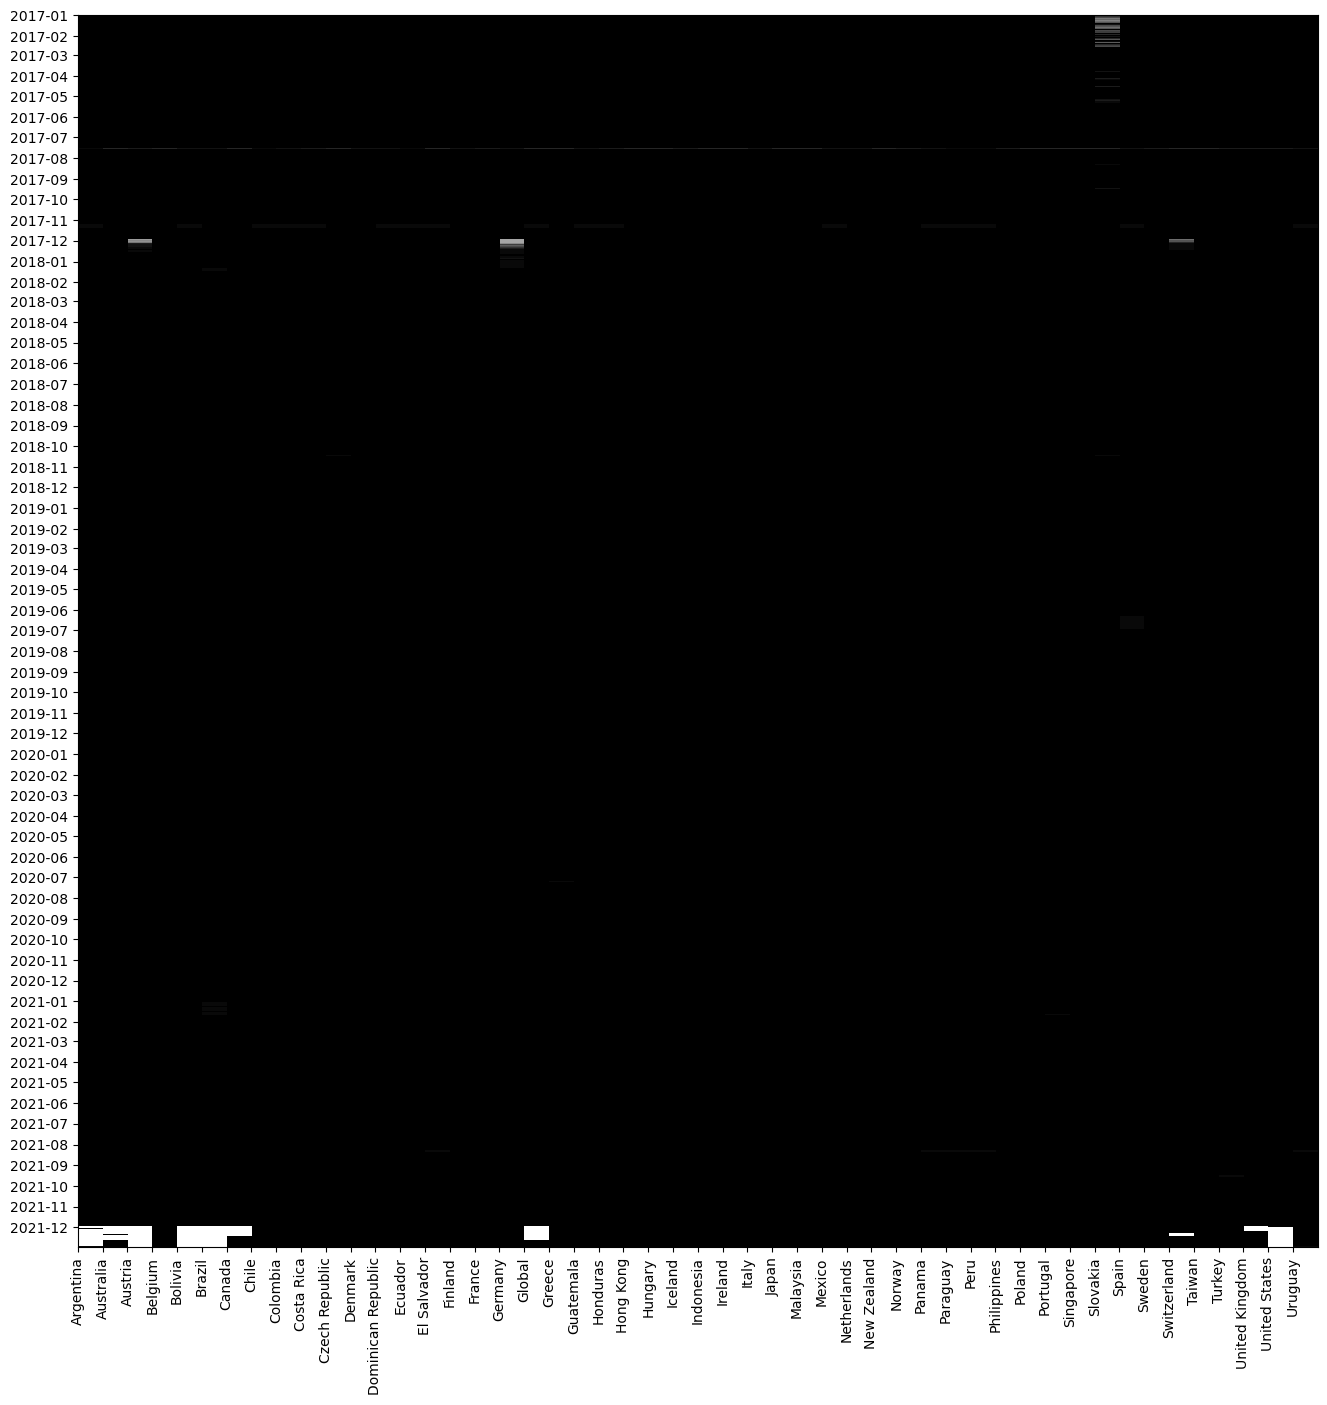

In [142]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

track_counts_per_region_and_date = final_data.reset_index().groupby(["region", "date"]).uri.count().rename("track_count").reset_index().set_index("date")

track_counts_by_region_pivot = track_counts_per_region_and_date.reset_index().pivot(
    columns=["region"], index="date", values="track_count"
)

plt.figure(figsize=(16, 16))
min_date = mdates.date2num(track_counts_per_region_and_date.index.min())
max_date = mdates.date2num(track_counts_per_region_and_date.index.max())

plt.xticks(ticks=list(range(len(track_counts_by_region_pivot.columns))), labels=track_counts_by_region_pivot.columns, rotation=90)

y_axis = plt.gca().yaxis
y_axis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
y_axis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
y_axis.set_major_locator(mdates.MonthLocator())

plt.imshow(
    track_counts_by_region_pivot,
    aspect="auto",
    extent=[0, 50, max_date, min_date],
    cmap="Greys",
    interpolation="none",
)
plt.show()

In [121]:
track_counts_per_region_and_date[track_counts_per_region_and_date.track_count < 45]

,region,track_count
date,,
2017-12-01,Austria,33
2017-12-02,Austria,33
2017-12-03,Austria,36
2017-12-04,Austria,34
2017-12-05,Austria,34
...,...,...
2021-07-02,Uruguay,44
2021-07-14,Uruguay,44
2021-07-22,Uruguay,43


In [122]:
len(final_data)

4417780

In [123]:
len(existing_data)

4477832

In [124]:
len(new_data)

86325

In [125]:
new_data[new_data.date >= "2021-12-01"]

,title,rank,date,artist,region,streams,uri,source
0,ベテルギウス,1,2021-12-13,Yuuri,Japan,215005,spotify:track:2sf18cEv463VgqmdjDsFpw,new
1,ドライフラワー,2,2021-12-13,Yuuri,Japan,206931,spotify:track:7dH0dpi751EoguDDg3xx6J,new
2,残響散歌,3,2021-12-13,Aimer,Japan,206079,spotify:track:7v8wKvNQQIxkugCFFjrkaO,new
3,一途,4,2021-12-13,King Gnu,Japan,201641,spotify:track:7ncPjJBktLEOpstY5JOUMK,new
4,なんでもないよ、,5,2021-12-13,Macaroni Empitsu,Japan,187740,spotify:track:2PFzK3kMDDYKhGnugvNYf1,new
...,...,...,...,...,...,...,...,...
45,drivers license,46,2021-12-05,Olivia Rodrigo,Ireland,17190,spotify:track:5wANPM4fQCJwkGd4rN57mH,new
46,Woman,47,2021-12-05,Doja Cat,Ireland,17078,spotify:track:6Uj1ctrBOjOas8xZXGqKk4,new
47,My Heart Goes (La Di Da) (feat. Topic),48,2021-12-05,"Becky Hill, Topic",Ireland,16897,spotify:track:2dWNKXTs5z7Iu1g0kYh4Xe,new
48,Santa Baby,49,2021-12-05,Kylie Minogue,Ireland,16855,spotify:track:2SBr3MK1sdMs8IxdRcN6qz,new
